In [3]:
# step 0 installs
%pip install transformers torch pandas numpy matplotlib networkx seaborn scikit-learn umap-learn

In [4]:
# step 0: imports
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import random
import seaborn as sns
from tqdm import tqdm
import umap.umap_ as umap

In [5]:
# step 1: Load model and tokenizer
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

tokenizer = AutoTokenizer.from_pretrained("InstaDeepAI/nucleotide-transformer-2.5b-multi-species")
model = AutoModelForMaskedLM.from_pretrained("InstaDeepAI/nucleotide-transformer-2.5b-multi-species")
model = model.to(device)
model.eval()

Using device: cpu


Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.89s/it]


EsmForMaskedLM(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(4105, 2560, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(1002, 2560, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-31): 32 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=2560, out_features=2560, bias=True)
              (key): Linear(in_features=2560, out_features=2560, bias=True)
              (value): Linear(in_features=2560, out_features=2560, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=2560, out_features=2560, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((2560,), eps=1e-12, elementwise_affine=True)
          )
          (int

In [6]:
#step 2: Define function to parse FASTA file
def parse_fasta(file_path):
    """Parse a FASTA file and return the full genome as a single string."""
    seqs = []
    seq = ''
    with open(file_path) as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith('>'):
                if seq:
                    seqs.append(seq)
                    seq = ''
            else:
                seq += line
        if seq:
            seqs.append(seq)
    return ''.join(seqs)

In [7]:
# step 3: Parse sequences from data files
strain_1 = parse_fasta('data\\GCA_006094915.1\\GCA_006094915.1_ASM609491v1_genomic.fna')[0]
strain_2 = parse_fasta('data\\GCA_026167765.1\\GCA_026167765.1_ASM2616776v1_genomic.fna')[0]
strain_3 = parse_fasta('data\\GCA_900607265.1\\GCA_900607265.1_BPH2003_genomic.fna')[0]
strain_4 = parse_fasta('data\\GCA_900620245.1\\GCA_900620245.1_BPH2947_genomic.fna')[0]

In [8]:
# step 4: Define helper to split genome into k-mers
def get_kmers(sequence, k=512, stride=256):
    """Split a sequence into overlapping k-mer chunks."""
    if len(sequence) < k:
        return [sequence]  # handle short sequences
    kmers = []
    for i in range(0, len(sequence) - k + 1, stride):
        kmers.append(sequence[i:i+k])
    return kmers

In [9]:
# step 5: Define embedding function (using k-mers)
def get_genome_embedding(sequence, k=512, stride=256, batch_size=4):
    kmers = get_kmers(sequence, k=k, stride=stride)
    if len(kmers) == 0:
        print(f"⚠️ No kmers generated for sequence length {len(sequence)}. Returning zeros.")
        return np.zeros(model.config.hidden_size)

    all_embeddings = []

    for i in tqdm(range(0, len(kmers), batch_size), desc="Computing k-mer embeddings"):
        batch = kmers[i:i+batch_size]
        tokens = tokenizer(batch, return_tensors="pt", padding=True, truncation=True,
                           max_length=min(k, tokenizer.model_max_length))
        tokens = {k: v.to(device) for k, v in tokens.items()}

        with torch.no_grad():
            outputs = model(**tokens, output_hidden_states=True)
            embeddings = outputs.hidden_states[-1]
            attention_mask = tokens["attention_mask"].unsqueeze(-1)
            masked_embeddings = embeddings * attention_mask
            mean_emb = masked_embeddings.sum(dim=1) / attention_mask.sum(dim=1)
            all_embeddings.append(mean_emb.cpu().numpy())

    all_embeddings = np.concatenate(all_embeddings, axis=0)
    mean_embedding = np.mean(all_embeddings, axis=0)
    return mean_embedding

In [10]:
# step 6: Compute embeddings for each strain
embedding_for_strain_1 = get_genome_embedding(strain_1, k=512, stride=256, batch_size=4)
embedding_for_strain_2 = get_genome_embedding(strain_2, k=512, stride=256, batch_size=4)
embedding_for_strain_3 = get_genome_embedding(strain_3, k=512, stride=256, batch_size=4)
embedding_for_strain_4 = get_genome_embedding(strain_4, k=512, stride=256, batch_size=4)

Computing k-mer embeddings:   0%|          | 0/1 [00:00<?, ?it/s]

Computing k-mer embeddings: 100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


In [ ]:

# step 6b: Combine embeddings into a DataFrame
headers = ['strain_1', 'strain_2', 'strain_3', 'strain_4']
embeddings = [
    embedding_for_strain_1,
    embedding_for_strain_2,
    embedding_for_strain_3,
    embedding_for_strain_4
]

df_all = pd.DataFrame({
    'Header': headers,
    'embedding': embeddings
})

df_all.to_pickle("genome_embeddings.pkl")
print("\n✅ Genome embeddings saved to genome_embeddings.pkl")


✅ Genome embeddings saved to genome_embeddings.pkl


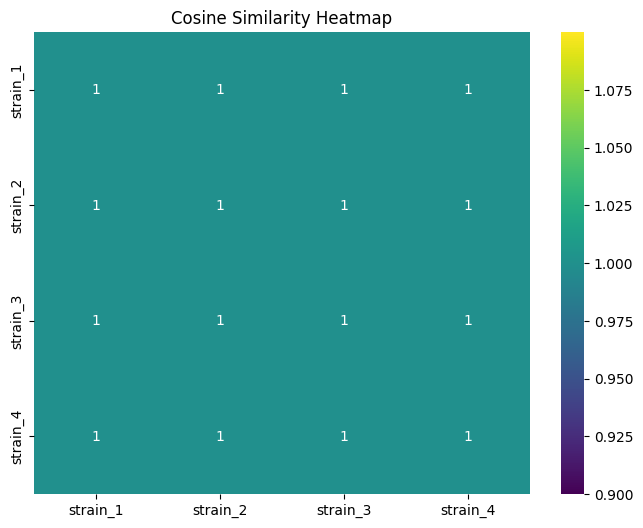

     Header  Cluster
0  strain_1        0
1  strain_2        0
2  strain_3        0
3  strain_4        0


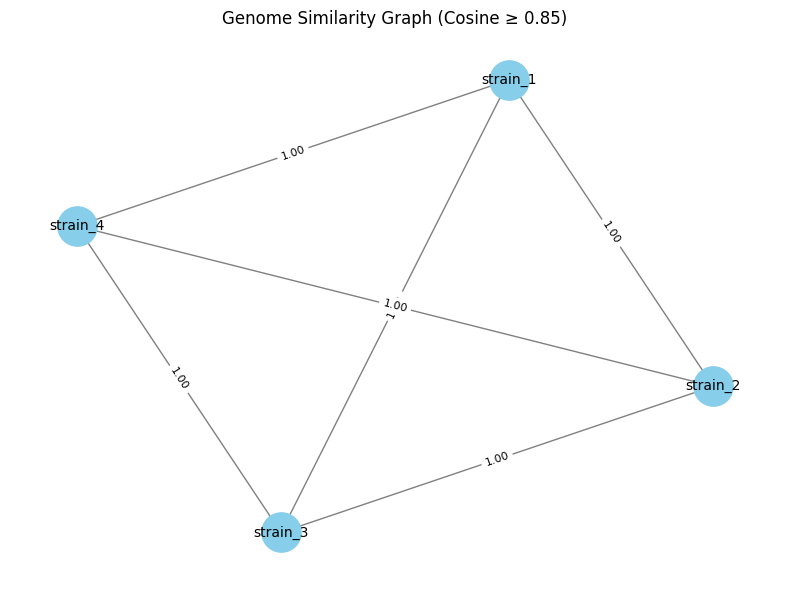

c:\Users\yalin\anaconda3\envs\dna_embed\lib\site-packages\sklearn\decomposition\_pca.py:640: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


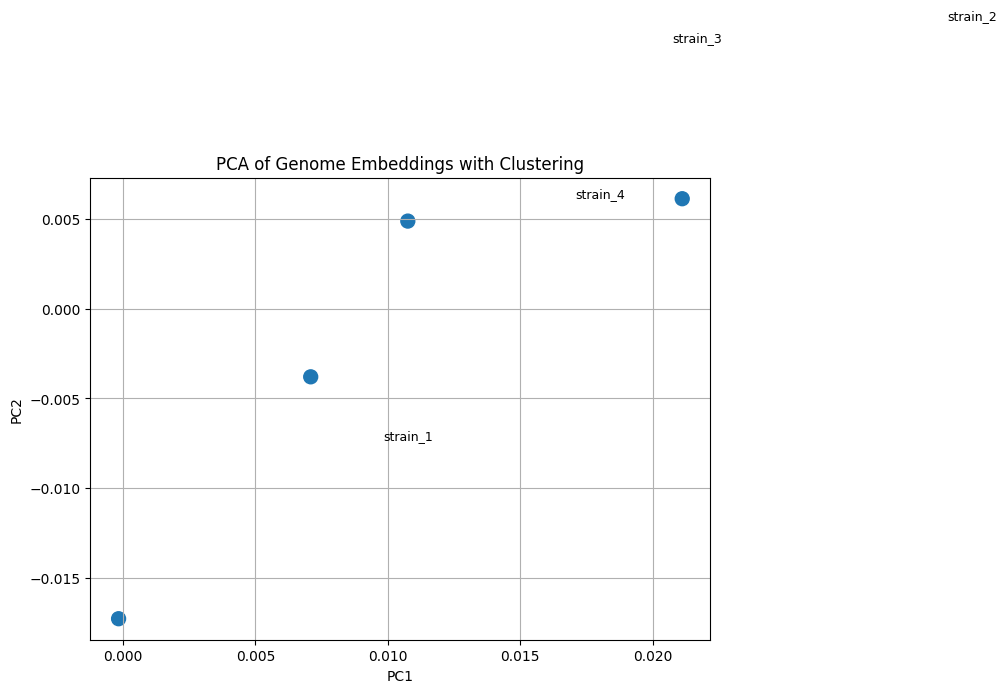

In [14]:
# step 7: Cosine similarity matrix
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

# Stack embeddings into a matrix
X = np.stack(df_all['embedding'].values)

# Compute cosine similarity
similarity_matrix = cosine_similarity(X)

# Optional: Visualize similarity matrix
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix, xticklabels=df_all['Header'], yticklabels=df_all['Header'], 
            annot=True, cmap='viridis')
plt.title("Cosine Similarity Heatmap")
plt.show()

# step 8: Clustering with DBSCAN

from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=0.1, min_samples=2, metric='cosine').fit(X)
df_all['Cluster'] = clustering.labels_
print(df_all[['Header', 'Cluster']])

# step 9: Build genome similarity graph
threshold = 0.85  # only connect highly similar genomes
G = nx.Graph()

# Add nodes
for label in df_all['Header']:
    G.add_node(label)

# Add edges for similarity above threshold
for i, label_i in enumerate(df_all['Header']):
    for j in range(i+1, len(df_all)):
        if similarity_matrix[i][j] >= threshold:
            G.add_edge(label_i, df_all['Header'][j], weight=similarity_matrix[i][j])

# step 10: Visualize genome similarity graph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=800)
nx.draw_networkx_edges(G, pos, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=10)
edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("Genome Similarity Graph (Cosine ≥ 0.85)")
plt.axis('off')
plt.tight_layout()
plt.show()

# step 11: PCA visualization with cluster coloring
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Add jitter to avoid overlapping points
jitter = np.random.normal(0, 0.01, X_pca.shape)
X_pca_jittered = X_pca + jitter

# Map cluster labels to colors
unique_clusters = sorted(df_all['Cluster'].unique())
color_map = {cluster: plt.cm.tab10(i % 10) for i, cluster in enumerate(unique_clusters)}
colors = [color_map[c] for c in df_all['Cluster']]

plt.figure(figsize=(8,6))
plt.scatter(X_pca_jittered[:,0], X_pca_jittered[:,1], c=colors, s=100)
for i, label in enumerate(df_all['Header']):
    plt.text(X_pca_jittered[i,0]+0.01, X_pca_jittered[i,1]+0.01, label, fontsize=9)
plt.title("PCA of Genome Embeddings with Clustering")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


In [26]:
# step 6b: Get k-mer embeddings for each genome (without averaging)
def get_genome_kmer_embeddings(sequence, k=512, stride=256, batch_size=4):
    kmers = get_kmers(sequence, k=k, stride=stride)
    if len(kmers) == 0:
        print(f"⚠️ Sequence too short ({len(sequence)} bp). Returning zeros.")
        return np.zeros((1, model.config.hidden_size))

    all_embeddings = []

    for i in tqdm(range(0, len(kmers), batch_size), desc="Computing k-mer embeddings"):
        batch = kmers[i:i+batch_size]
        tokens = tokenizer(batch, return_tensors="pt", padding=True, truncation=True,
                           max_length=min(k, tokenizer.model_max_length))
        tokens = {k: v.to(device) for k, v in tokens.items()}

        with torch.no_grad():
            outputs = model(**tokens, output_hidden_states=True)
            embeddings = outputs.hidden_states[-1]
            attention_mask = tokens["attention_mask"].unsqueeze(-1)
            masked_embeddings = embeddings * attention_mask
            mean_emb = masked_embeddings.sum(dim=1) / attention_mask.sum(dim=1)
            all_embeddings.append(mean_emb.cpu().numpy())

    return np.concatenate(all_embeddings, axis=0)  # shape = (num_kmers, embedding_dim)

# step 6c: Compute k-mer embeddings for all strains
k, stride = 512, 256
strain_embeddings = {}
for name, seq in zip(['strain_1','strain_2','strain_3','strain_4'],
                     [strain_1, strain_2, strain_3, strain_4]):
    strain_embeddings[name] = get_genome_kmer_embeddings(seq, k=k, stride=stride, batch_size=4)
    print(f"{name} embeddings shape: {strain_embeddings[name].shape}")

Computing k-mer embeddings: 100%|██████████| 1/1 [00:44<00:00, 44.36s/it]


strain_1 embeddings shape: (1, 2560)


Computing k-mer embeddings: 100%|██████████| 1/1 [00:09<00:00,  9.91s/it]


strain_2 embeddings shape: (1, 2560)


Computing k-mer embeddings: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


strain_3 embeddings shape: (1, 2560)


Computing k-mer embeddings: 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]

strain_4 embeddings shape: (1, 2560)


In [17]:
# step 7: Create a DataFrame with embeddings
headers = ['strain_1', 'strain_2', 'strain_3', 'strain_4']
embeddings = [
    embedding_for_strain_1,
    embedding_for_strain_2,
    embedding_for_strain_3,
    embedding_for_strain_4
]

df_all = pd.DataFrame({
    'Header': headers,
    'embedding': embeddings
})

df_all.to_pickle("genome_embeddings.pkl")
print("\n✅ Genome embeddings saved to genome_embeddings.pkl")


✅ Genome embeddings saved to genome_embeddings.pkl


c:\Users\yalin\anaconda3\envs\dna_embed\lib\site-packages\sklearn\decomposition\_pca.py:640: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


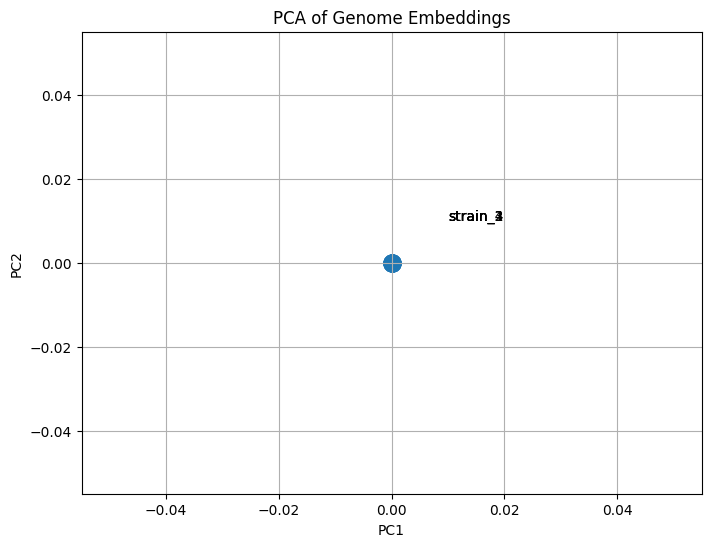

In [28]:
# step 7b: PCA/UMAP for all k-mer embeddings
from sklearn.decomposition import PCA

all_kmers = []
labels = []
for name, emb in strain_embeddings.items():
    all_kmers.append(emb)
    labels.extend([name]*emb.shape[0])

all_kmers = np.vstack(all_kmers)  # shape = (total_kmers, embedding_dim)
labels = np.array(labels)

# Genome-level embeddings (mean of k-mers per genome)
X_genome = np.vstack([strain_embeddings[name].mean(axis=0) for name in strain_embeddings])

# PCA directly to 2D for plotting
from sklearn.decomposition import PCA

pca2 = PCA(n_components=2)
X_2d = pca2.fit_transform(X_genome)

plt.figure(figsize=(8,6))
plt.scatter(X_2d[:,0], X_2d[:,1], s=150)
for i, name in enumerate(strain_embeddings.keys()):
    plt.text(X_2d[i,0]+0.01, X_2d[i,1]+0.01, name, fontsize=10)
plt.title("PCA of Genome Embeddings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


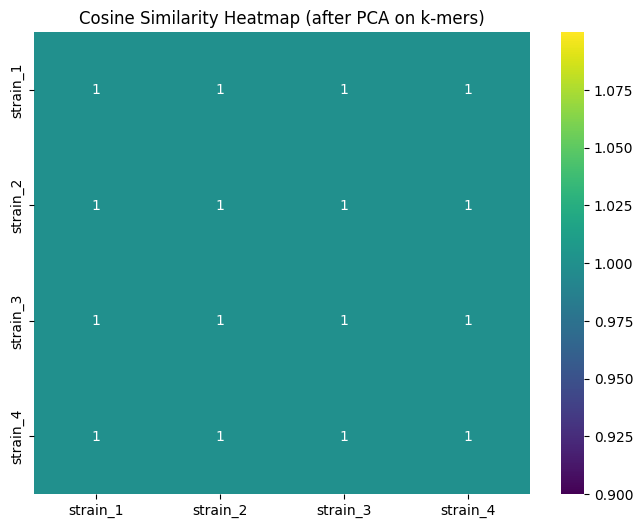

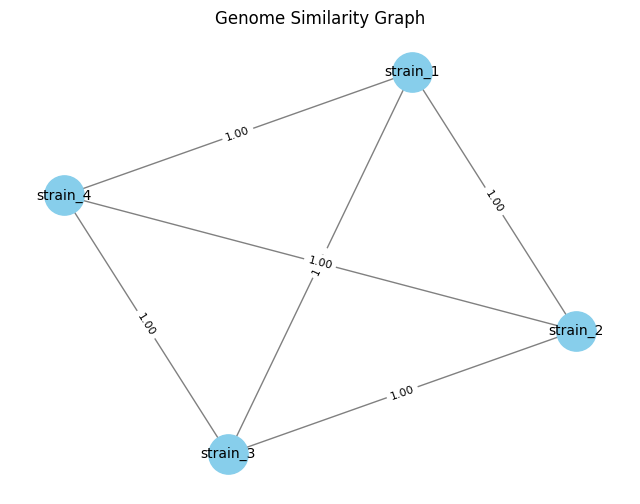

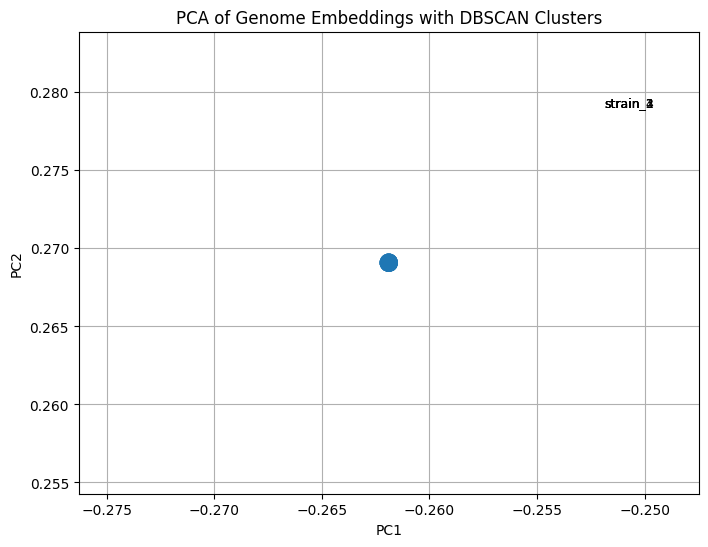

In [ ]:
# step 8b: Cosine similarity between genomes (using k-mer means)
# Take mean of k-mer embeddings per genome (after PCA)
X_genome = np.vstack([strain_embeddings[name].mean(axis=0) for name in strain_embeddings])
similarity_matrix = cosine_similarity(X_genome)

plt.figure(figsize=(8,6))
sns.heatmap(similarity_matrix, xticklabels=strain_embeddings.keys(), yticklabels=strain_embeddings.keys(),
            annot=True, cmap='viridis')
plt.title("Cosine Similarity Heatmap (after PCA on k-mers)")
plt.show()

# step 9b: Genome similarity graph
import networkx as nx
threshold = 0.85
G = nx.Graph()
for i, name_i in enumerate(strain_embeddings.keys()):
    G.add_node(name_i)
    for j in range(i+1, len(strain_embeddings)):
        if similarity_matrix[i,j] >= threshold:
            G.add_edge(name_i, list(strain_embeddings.keys())[j], weight=similarity_matrix[i,j])

plt.figure(figsize=(8,6))
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=800)
nx.draw_networkx_edges(G, pos, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=10)
edge_labels = {(u,v): f"{d['weight']:.2f}" for u,v,d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("Genome Similarity Graph")
plt.axis('off')
plt.show()

# step 10b: PCA visualization of genomes with clusters
# Assign clusters using DBSCAN on genome-level mean embeddings
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=0.1, min_samples=1, metric='cosine').fit(X_genome)
cluster_labels = clustering.labels_

plt.figure(figsize=(8,6))
colors = [plt.cm.tab10(c % 10) for c in cluster_labels]
plt.scatter(X_genome[:,0], X_genome[:,1], c=colors, s=150)
for i, name in enumerate(strain_embeddings.keys()):
    plt.text(X_genome[i,0]+0.01, X_genome[i,1]+0.01, name, fontsize=9)
plt.title("PCA of Genome Embeddings with DBSCAN Clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

In [ ]:
print(similarity_matrix)

[[0.9999997 0.9999997 0.9999997 0.9999997]
 [0.9999997 0.9999997 0.9999997 0.9999997]
 [0.9999997 0.9999997 0.9999997 0.9999997]
 [0.9999997 0.9999997 0.9999997 0.9999997]]


In [1]:
# step 0 installs
%pip install transformers torch pandas numpy matplotlib networkx seaborn scikit-learn umap-learn

# =====================================================
# step 0: imports
# =====================================================
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN
import networkx as nx
import umap  # Make sure umap-learn is installed: pip install umap-learn

# =====================================================
# step 1: load model
# =====================================================
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained("InstaDeepAI/nucleotide-transformer-2.5b-multi-species")
model = AutoModelForMaskedLM.from_pretrained("InstaDeepAI/nucleotide-transformer-2.5b-multi-species")
model.to(device)
model.eval()

# =====================================================
# step 2: robust FASTA parser
# =====================================================
def parse_fasta(file_path):
    seq = ''
    with open(file_path) as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith('>'):
                continue
            seq += line
    return seq

# =====================================================
# step 3: parse strains
# =====================================================
strain_files = [
    'data\\GCA_006094915.1\\GCA_006094915.1_ASM609491v1_genomic.fna',
    'data\\GCA_026167765.1\\GCA_026167765.1_ASM2616776v1_genomic.fna',
    'data\\GCA_900607265.1\\GCA_900607265.1_BPH2003_genomic.fna',
    'data\\GCA_900620245.1\\GCA_900620245.1_BPH2947_genomic.fna'
]
strain_names = ['strain_1', 'strain_2', 'strain_3', 'strain_4']
strains = [parse_fasta(f) for f in strain_files]

# =====================================================
# step 4: split genome into k-mers
# =====================================================
def get_kmers(sequence, k=512, stride=256):
    if len(sequence) <= k:
        return [sequence]
    kmers = [sequence[i:i+k] for i in range(0, len(sequence)-k+1, stride)]
    return kmers

# =====================================================
# step 5: get k-mer embeddings
# =====================================================
def get_kmer_embeddings(sequence, k=512, stride=256, batch_size=4):
    kmers = get_kmers(sequence, k=k, stride=stride)
    embeddings_list = []
    for i in tqdm(range(0, len(kmers), batch_size), desc="Computing k-mer embeddings"):
        batch = kmers[i:i+batch_size]
        tokens = tokenizer(batch, return_tensors="pt", padding=True, truncation=True,
                           max_length=min(k, tokenizer.model_max_length))
        tokens = {k: v.to(device) for k,v in tokens.items()}
        with torch.no_grad():
            outputs = model(**tokens, output_hidden_states=True)
            hidden = outputs.hidden_states[-1]  # last layer
            attn = tokens['attention_mask'].unsqueeze(-1)
            masked = hidden * attn
            mean_emb = masked.sum(dim=1) / attn.sum(dim=1)
            embeddings_list.append(mean_emb.cpu().numpy())
    return np.vstack(embeddings_list)  # shape = (num_kmers, embedding_dim)

# =====================================================
# step 6: compute embeddings for all strains
# =====================================================
strain_embeddings = {}
for name, seq in zip(strain_names, strains):
    emb = get_kmer_embeddings(seq, k=512, stride=256, batch_size=4)
    print(f"{name} k-mer embeddings shape: {emb.shape}")
    strain_embeddings[name] = emb

# =====================================================
# step 7: stack all k-mers and reduce dimensionality with UMAP
# =====================================================
all_kmers = []
labels = []
for name, emb in strain_embeddings.items():
    all_kmers.append(emb)
    labels.extend([name]*emb.shape[0])
all_kmers = np.vstack(all_kmers)
labels = np.array(labels)

# UMAP to 10D
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', n_components=10, random_state=42)
X_umap = reducer.fit_transform(all_kmers)

# Compute mean embedding per genome in UMAP space
X_genome_umap = []
for name in strain_names:
    X_genome_umap.append(X_umap[labels==name].mean(axis=0))
X_genome_umap = np.vstack(X_genome_umap)

# =====================================================
# step 8: Cosine similarity heatmap
# =====================================================
sim_matrix = cosine_similarity(X_genome_umap)
plt.figure(figsize=(8,6))
sns.heatmap(sim_matrix, xticklabels=strain_names, yticklabels=strain_names, annot=True, cmap='viridis')
plt.title("Cosine Similarity Heatmap (UMAP-reduced embeddings)")
plt.show()

# =====================================================
# step 9: Genome similarity graph
# =====================================================
threshold = 0.85
G = nx.Graph()
for i, name_i in enumerate(strain_names):
    G.add_node(name_i)
    for j in range(i+1, len(strain_names)):
        if sim_matrix[i,j] >= threshold:
            G.add_edge(name_i, strain_names[j], weight=sim_matrix[i,j])

plt.figure(figsize=(8,6))
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=800)
nx.draw_networkx_edges(G, pos, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=10)
edge_labels = {(u,v): f"{d['weight']:.2f}" for u,v,d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("Genome Similarity Graph")
plt.axis('off')
plt.show()

# =====================================================
# step 10: PCA visualization of genomes with clusters
# =====================================================
clustering = DBSCAN(eps=0.1, min_samples=1, metric='cosine').fit(X_genome_umap)
cluster_labels = clustering.labels_

plt.figure(figsize=(8,6))
colors = [plt.cm.tab10(c % 10) for c in cluster_labels]
plt.scatter(X_genome_umap[:,0], X_genome_umap[:,1], c=colors, s=150)
for i, name in enumerate(strain_names):
    plt.text(X_genome_umap[i,0]+0.01, X_genome_umap[i,1]+0.01, name, fontsize=10)
plt.title("Genome Embeddings PCA/UMAP with DBSCAN Clusters")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.grid(True)
plt.show()

Note: you may need to restart the kernel to use updated packages.


c:\Users\yalin\anaconda3\envs\dna_embed\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Computing k-mer embeddings:  13%|█▎        | 356/2717 [1:44:34<11:33:34, 17.63s/it]


KeyboardInterrupt: 